In [ ]:
import pandas as pd

import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsmodels.tsa.seasonal import STL

from statsforecast.models import (
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
    AutoTheta,
)

from utilsforecast.losses import mae, rmse
from utilsforecast.evaluation import evaluate

import os


os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

In [6]:
df = pd.read_csv("./cw-business-applications.csv")
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1034 entries, 0 to 1033
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1034 non-null   str    
 1   y       1033 non-null   float64
dtypes: float64(1), str(1)
memory usage: 26.3 KB


In [7]:
df.head()

,DATE,y
0,01/01/2006,39580.0
1,08/01/2006,36920.0
2,15/01/2006,63300.0
3,22/01/2006,51910.0
4,29/01/2006,61430.0


In [8]:
df = pd.read_csv("./cw-business-applications.csv")

# DD/MM/YYYY format
df['DATE'] = pd.to_datetime(df['DATE'], format='%d/%m/%Y')
df = df.sort_values('DATE').reset_index(drop=True)

df = df.rename(columns={'DATE': 'ds'})
df['unique_id'] = 'business-application'
df = df[['unique_id', 'ds', 'y']]

df.head()

,unique_id,ds,y
0,business-application,2006-01-01,39580.0
1,business-application,2006-01-08,36920.0
2,business-application,2006-01-15,63300.0
3,business-application,2006-01-22,51910.0
4,business-application,2006-01-29,61430.0


In [9]:
# linear interpolation for missing values

df = df.sort_values("ds")
df["y"] = df["y"].interpolate(method="linear")

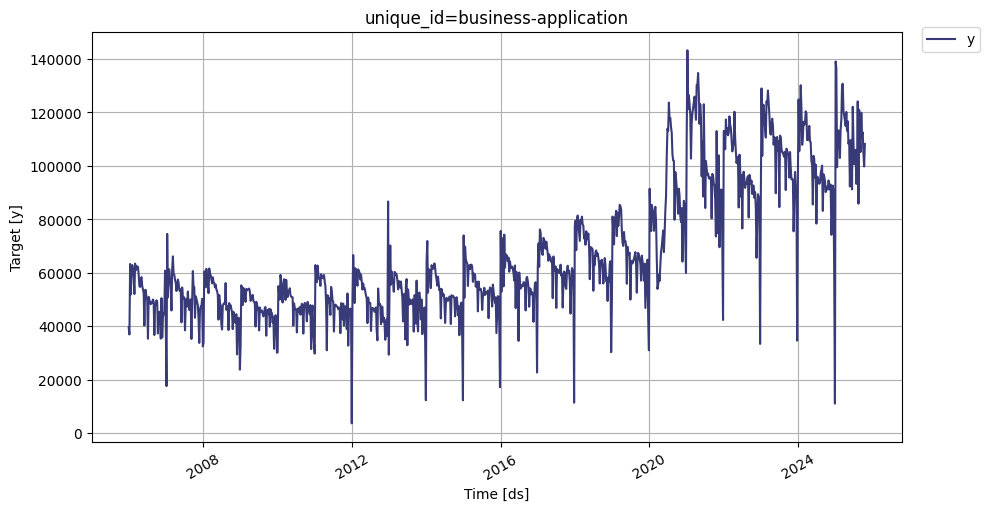

In [10]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(5)
f

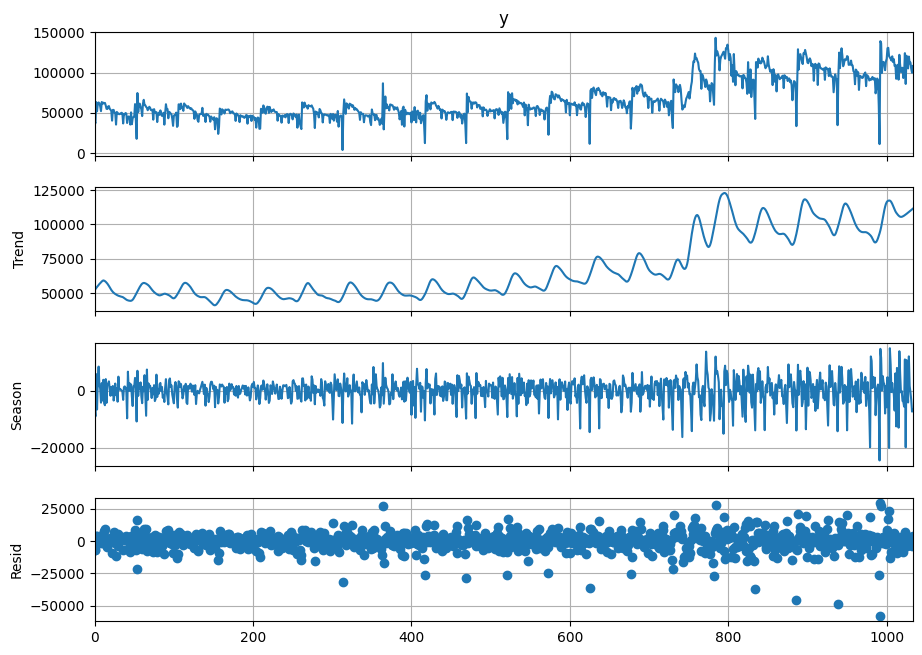

In [11]:
res = STL(df['y'], period=12).fit()

f = res.plot()
f.set_figwidth(10)
f.set_figheight(7)

Cut-off pre-covid

In [12]:
df = df[df["ds"] >= "2020-01-01"]

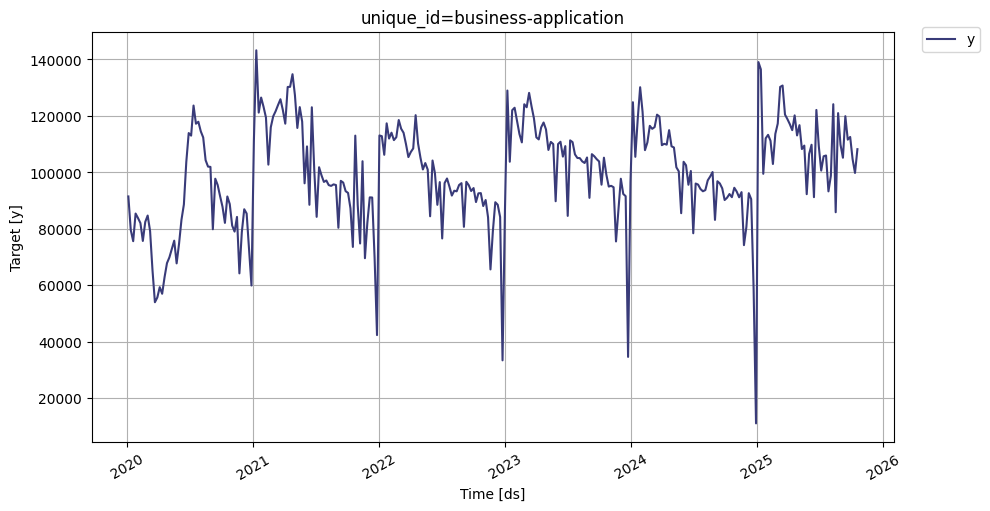

In [13]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(5)
f

In [14]:
# weekly seasonality
season_length = 52
forecast_horizon = 10

sf = StatsForecast(
    models=[
        SeasonalNaive(season_length=season_length),
        AutoARIMA(season_length=season_length),
        AutoETS(season_length=season_length),
        AutoTheta(season_length=season_length),
    ],
    freq="W-SUN",
    n_jobs=-1,
)

sf.fit(df)

StatsForecast(models=[SeasonalNaive,AutoARIMA,AutoETS,AutoTheta])

In [15]:
forecast_df = sf.predict(h=forecast_horizon)
forecast_df

,unique_id,ds,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta
0,business-application,2025-10-26,94540.0,105362.031857,106530.638444,101422.120907
1,business-application,2025-11-02,93190.0,101819.384661,106530.638444,97930.713535
2,business-application,2025-11-09,91170.0,102716.952226,106530.638444,103710.969356
3,business-application,2025-11-16,93000.0,97149.348011,106530.638444,83258.599439
4,business-application,2025-11-23,74210.0,88518.718843,106530.638444,90639.722428
5,business-application,2025-11-30,80630.0,96280.738213,106530.638444,100700.234904
6,business-application,2025-12-07,92630.0,103071.287520,106530.638444,101676.840252
7,business-application,2025-12-14,90500.0,100444.231018,106530.638444,92322.056751
8,business-application,2025-12-21,58840.0,62115.041640,106530.638444,51671.091488
9,business-application,2025-12-28,11050.0,50037.823775,106530.638444,94514.062617


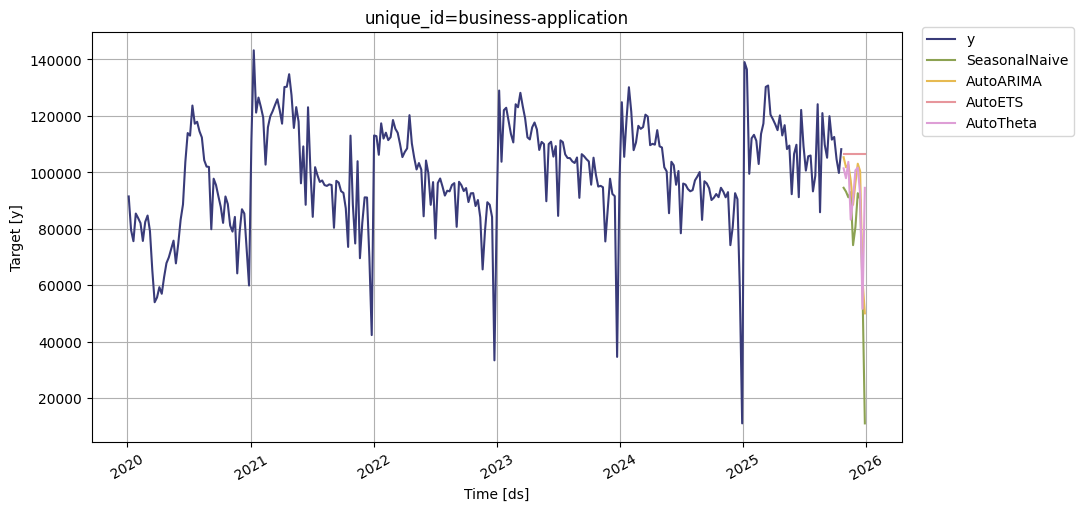

In [16]:
# two baselines
f = sf.plot(df, forecast_df, models=['SeasonalNaive', 'AutoARIMA', 'AutoETS', 'AutoTheta'])
f.set_figwidth(9)
f.set_figheight(5)
f

In [17]:
cv_df = sf.cross_validation(
    df=df,
    h=10,           # 10 weeks ahead
    step_size=4,    # slide 4 weeks at a time
    n_windows=8,    # 2 years of val
)

cv_df.tail()

,unique_id,ds,cutoff,y,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta
75,business-application,2025-09-21,2025-08-10,111600.0,94350.0,108686.975264,109991.080535,101651.614978
76,business-application,2025-09-28,2025-08-10,112550.0,90200.0,105755.975318,109991.080535,99655.613667
77,business-application,2025-10-05,2025-08-10,104700.0,91010.0,103905.154512,109991.080535,94509.266630
78,business-application,2025-10-12,2025-08-10,99800.0,92320.0,106884.020664,109991.080535,96373.868996
79,business-application,2025-10-19,2025-08-10,108220.0,91210.0,105786.666349,109991.080535,102540.833009


In [18]:
eval_df = evaluate(
    cv_df,
    metrics=[mae, rmse],
    train_df=df,
)

eval_df

,unique_id,cutoff,metric,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta
0,business-application,2025-01-26,mae,6530.000000,6853.718899,11024.771154,7647.302143
1,business-application,2025-02-23,mae,6544.000000,10293.920549,10002.760776,8590.833877
2,business-application,2025-03-23,mae,6343.000000,3204.884531,11210.468232,3523.258801
3,business-application,2025-04-20,mae,10105.000000,6684.421803,11483.942145,7335.502282
4,business-application,2025-05-18,mae,10026.000000,7327.811688,9942.638149,9151.000213
5,business-application,2025-06-15,mae,14467.000000,13624.852430,11020.325464,12281.245899
6,business-application,2025-07-13,mae,15356.000000,11273.820617,9788.531926,13018.056887
7,business-application,2025-08-10,mae,17011.000000,7784.884764,7147.216107,11354.630584
8,business-application,2025-01-26,rmse,7687.181538,8957.608508,12881.270755,9284.965557
9,business-application,2025-02-23,rmse,7600.918366,10996.073447,11504.972801,9928.907653


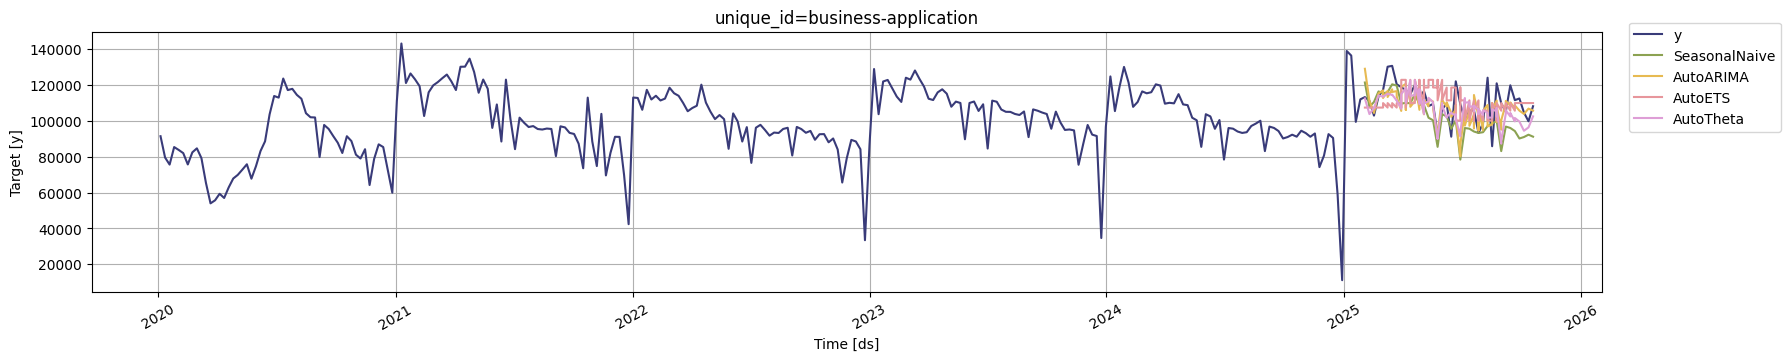

In [19]:
StatsForecast.plot(
    df,
    cv_df[['unique_id', 'ds', 'SeasonalNaive', 'AutoARIMA', 'AutoETS', 'AutoTheta']]
)

#ML

In [20]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import RollingMean, RollingStd

from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
import lightgbm as lgb

In [21]:
mlf = MLForecast(
    models={
        'Ridge'    : Ridge(),
        'LGB'      : lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, verbosity=-1),
        'CatBoost' : CatBoostRegressor(iterations=500, learning_rate=0.05, verbose=0),
    },

    freq='W-SUN',

    # lag features
    # weekly seasonality + trend
    lags=[1, 2, 3, 4, 52, 53, 104],

    lag_transforms={
        1  : [RollingMean(window_size=4),      # 1-month rolling
               RollingStd(window_size=4)],
        4  : [RollingMean(window_size=52),     # 1-year rolling mean
               RollingStd(window_size=52)],
        52 : [RollingMean(window_size=4)],     # seasonal rolling
    },

    # calendar features
    date_features=['year', 'month', 'week'],

    # stabilizes variance and remove trend before training
    # seasonal diff
    # trend diff
    target_transforms=[
        Differences([52]),
        Differences([1]),
    ],
)

mlf

MLForecast(models=[Ridge, LGB, CatBoost], freq=W-SUN, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag52', 'lag53', 'lag104', 'rolling_mean_lag1_window_size4', 'rolling_std_lag1_window_size4', 'rolling_mean_lag4_window_size52', 'rolling_std_lag4_window_size52', 'rolling_mean_lag52_window_size4'], date_features=['year', 'month', 'week'], num_threads=1)

In [22]:
cv_mlf = mlf.cross_validation(
    df=df,
    h=10,
    step_size=4,
    n_windows=8,
    fitted=True,
)

cv_mlf.tail()

,unique_id,ds,cutoff,y,Ridge,LGB,CatBoost
75,business-application,2025-09-21,2025-08-10,111600.0,100324.857712,94422.565078,123464.359025
76,business-application,2025-09-28,2025-08-10,112550.0,99314.104276,109722.327178,122831.976857
77,business-application,2025-10-05,2025-08-10,104700.0,100801.308669,92568.771402,128344.220290
78,business-application,2025-10-12,2025-08-10,99800.0,101955.328213,81613.901140,124796.048707
79,business-application,2025-10-19,2025-08-10,108220.0,98159.114736,87659.516238,128880.458456


In [23]:
eval_mlf = evaluate(
    cv_mlf,
    metrics=[mae, rmse],
    train_df=df,
)

eval_mlf

,unique_id,cutoff,metric,Ridge,LGB,CatBoost
0,business-application,2025-01-26,mae,9075.208188,10250.283953,20991.184300
1,business-application,2025-02-23,mae,18505.441735,14139.552737,10456.084552
2,business-application,2025-03-23,mae,4461.129445,8694.517070,5872.562111
3,business-application,2025-04-20,mae,6541.442047,8942.449522,7051.524549
4,business-application,2025-05-18,mae,8165.614665,11110.217001,7591.257417
5,business-application,2025-06-15,mae,13326.502621,13188.752750,15615.644778
6,business-application,2025-07-13,mae,11416.049272,13267.655593,10536.225766
7,business-application,2025-08-10,mae,10692.572553,14076.277808,15014.450428
8,business-application,2025-01-26,rmse,10987.303379,12379.172640,22362.517166
9,business-application,2025-02-23,rmse,18748.822773,16827.636771,11368.960687


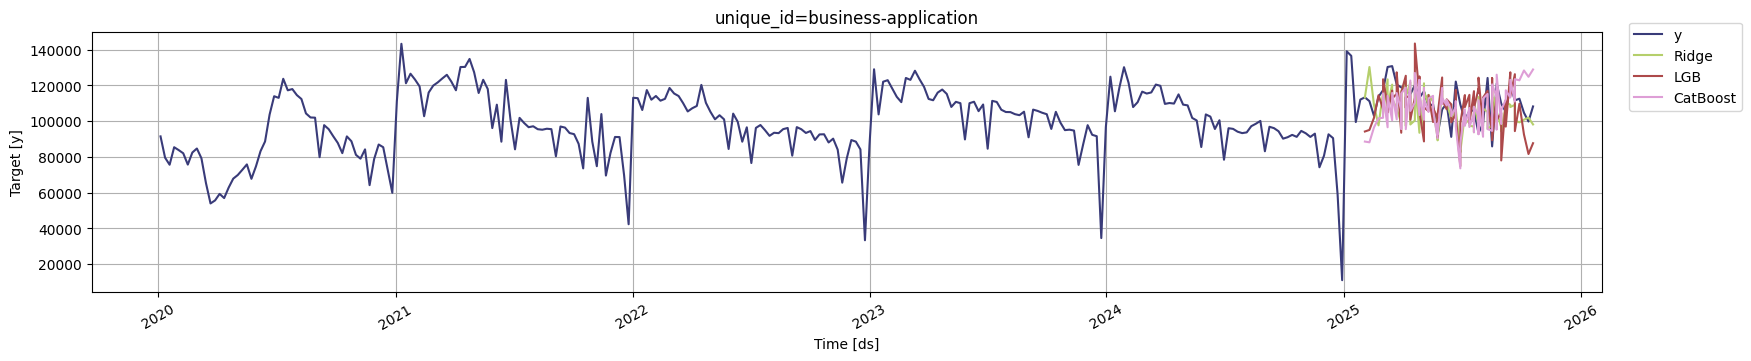

In [24]:
StatsForecast.plot(
    df,
    cv_mlf[['unique_id', 'ds', 'Ridge', 'LGB', 'CatBoost']]
)

Ensemble StatModels: AutoTheta + AutoARIMA

In [25]:
cv_df['Ensemble_Best'] = (
    cv_df['AutoTheta'] + cv_df['AutoARIMA']
) / 2

In [26]:
eval_final = evaluate(
    cv_df[['unique_id', 'ds', 'cutoff', 'y', 
           'SeasonalNaive', 'AutoARIMA', 'AutoTheta', 'Ensemble_Best']],
    metrics=[rmse],
    train_df=df,
)

eval_final[eval_final['metric'] == 'rmse'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

Ensemble_Best    10224.774613
AutoARIMA        10345.345250
AutoTheta        10752.793725
SeasonalNaive    12731.263452
dtype: float64

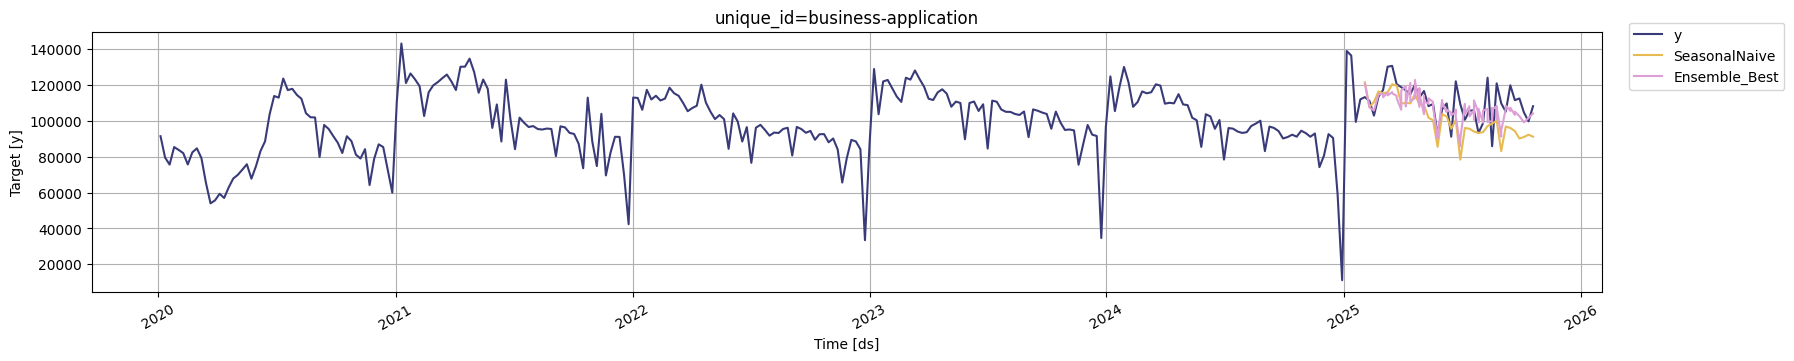

In [27]:
StatsForecast.plot(
    df,
    cv_df[['unique_id', 'ds', 'SeasonalNaive', 'Ensemble_Best']]
)

In [28]:
forecast_df['Ensemble_Best'] = (
    forecast_df['AutoTheta'] + forecast_df['AutoARIMA']
) / 2

forecast_df[['ds', 'Ensemble_Best']]

,ds,Ensemble_Best
0,2025-10-26,103392.076382
1,2025-11-02,99875.049098
2,2025-11-09,103213.960791
3,2025-11-16,90203.973725
4,2025-11-23,89579.220636
5,2025-11-30,98490.486558
6,2025-12-07,102374.063886
7,2025-12-14,96383.143885
8,2025-12-21,56893.066564
9,2025-12-28,72275.943196


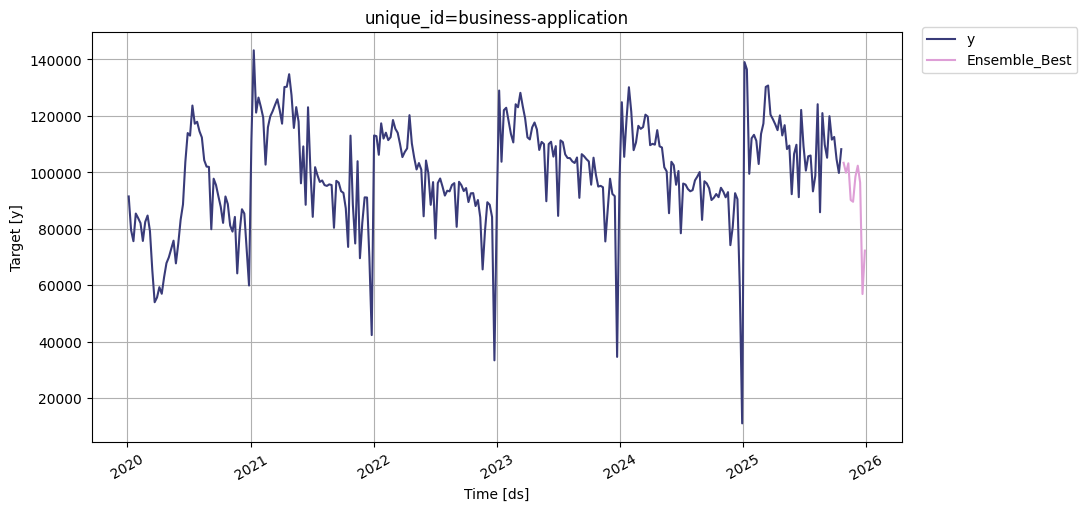

In [29]:
f = sf.plot(df, forecast_df, models=['Ensemble_Best'])
f.set_figwidth(9)
f.set_figheight(5)
f